# Galactic extinction correction

Parte da luz emitida pelo objeto observado é absorvida poeira interestelas da Via Láctea. Este notebook faz a correção deste defeito, levando em conta as coordenadas galácticas do objeto observado.

In [1]:
import json
import astropy.coordinates
import astropy.time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from dust_extinction.parameter_averages import G23

In [2]:
with open("sci_files_object_mapping.json", "r") as f:
    sci_files_object_mapping = json.load(f)

object_name = "GSN 069"
filename = f"redux/cstxeqxbrg{sci_files_object_mapping[object_name][0]}"


def get_galactic_coord(filename):
    with fits.open(filename) as hdul:
        header = hdul[0].header

    coord = astropy.coordinates.TETE(
        ra=header["RA"] * u.deg,
        dec=header["DEC"] * u.deg,
        obstime=astropy.time.Time(header["DATE-OBS"]),
    )

    coord = coord.transform_to(astropy.coordinates.Galactic())
    return coord.l.deg, coord.b.deg


get_galactic_coord(filename)

(266.0380720718457, -80.81866036697947)

In [3]:
name = object_name.replace(" ", "").lower()
filename = f"redux/{name}_combined_spectra.fits"
with fits.open(filename) as hdul:
    input_data = hdul["SCI"].data

fits_header = fits.getheader(filename, ext=("sci", 1))
wcs = WCS(fits_header, naxis=[1])
wavelength = wcs.wcs_pix2world(np.arange(fits_header["NAXIS1"]), 0)[0] * u.AA

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


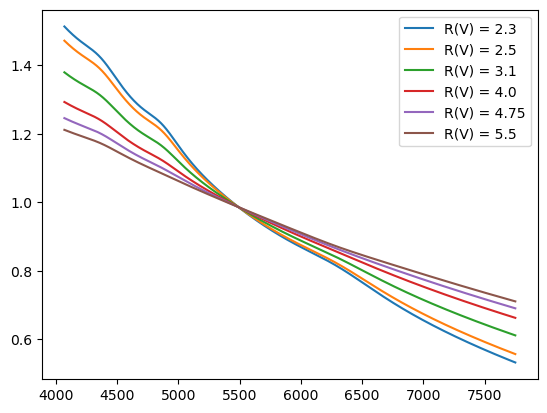

In [4]:
fig, ax = plt.subplots()
Rvs = [2.3, 2.5, 3.1, 4.0, 4.75, 5.5]
for Rv in Rvs:
    ext_model = G23(Rv=Rv)
    ax.plot(wavelength, ext_model(wavelength), label="R(V) = " + str(Rv))

ax.legend(loc="best")
plt.show()

In [5]:
u_flux = u.erg / (u.cm**2 * u.s * u.AA)

Rv = 3.08
Ebv = 0.024
ext_model = G23(Rv)
correction_factor = ext_model.extinguish(wavelength, Ebv=Ebv)
# input_data = fits_dic['GSN 069']['SCI']
unestinguished_spectra = np.zeros(input_data.shape)
for index, spectrum in enumerate(input_data):
    flux = spectrum * u_flux
    unestinguished_spectra[index] = flux / correction_factor

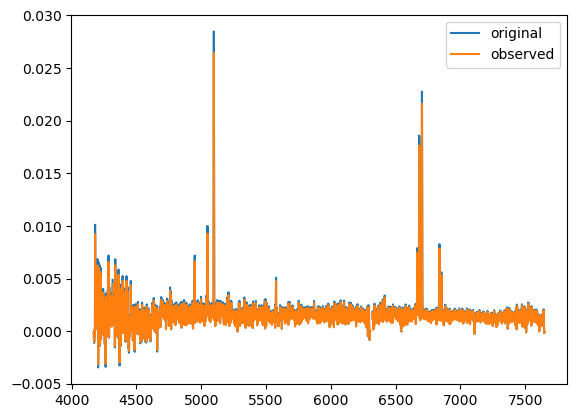

In [6]:
fiber = 600
plt.plot(wavelength, unestinguished_spectra[fiber], label="original")
plt.plot(wavelength, input_data[fiber], label="observed")
plt.legend()

In [ ]:
name = "gsn069"
filename = f"redux/{name}_combined_spectra.fits"
new_filename = f"redux/{name}_combined_spectra_ext.fits"
with fits.open(filename) as hdul:
    hdul["SCI"].data = unestinguished_spectra
    hdul.writeto(new_filename, overwrite=True)